In [1]:
! pip install datasets
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from datasets import load_dataset
from tqdm import tqdm
import pandas as pd
from termcolor import colored
from collections import Counter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 16.2 MB/s eta 0:00:00


# <font color="chillipepper">**Dataset Importation** </font>

In [2]:
dataset = load_dataset("silicone", "dyda_da")

Generating train split:   0%|          | 0/87170 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8069 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7740 [00:00<?, ? examples/s]

Dataset silicone downloaded and prepared to /root/.cache/huggingface/datasets/silicone/dyda_da/1.0.0/af617406c94e3f78da85f7ea74ebfbd3f297a9665cb54adbae305b03bc4442a5. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Utterance', 'Dialogue_Act', 'Dialogue_ID', 'Label', 'Idx'],
        num_rows: 87170
    })
    validation: Dataset({
        features: ['Utterance', 'Dialogue_Act', 'Dialogue_ID', 'Label', 'Idx'],
        num_rows: 8069
    })
    test: Dataset({
        features: ['Utterance', 'Dialogue_Act', 'Dialogue_ID', 'Label', 'Idx'],
        num_rows: 7740
    })
})

In [4]:
#Labels
names = list(set(dataset['train']['Dialogue_Act']))
names

['question', 'inform', 'directive', 'commissive']

# <font color="chillipepper">**Data Preporcessing** </font>

In [5]:
def adjust_labels(entries):
    res = {}
    res['text'] = entries['Utterance']
    res['labels'] = [ label for label in entries['Label']]
    return res

for split in ['train', 'validation', 'test']:
    rows_to_select = [ i for i, entry in enumerate(dataset[split])]
    dataset[split] = dataset[split].select(rows_to_select)
    dataset[split] = dataset[split].map(lambda e: adjust_labels(e)  , batched=True)

Map:   0%|          | 0/87170 [00:00<?, ? examples/s]

Map:   0%|          | 0/8069 [00:00<?, ? examples/s]

Map:   0%|          | 0/7740 [00:00<?, ? examples/s]

# <font color="chillipepper">**Tokenization** </font>

In [6]:
!pip install transformers
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(Data):
  return tokenizer(Data['text'], padding = "max_length", max_length=36, pad_to_max_length=True,
                                           truncation=True, return_token_type_ids=False)

tokenized_datasets = dataset.map(tokenize_function, batched = True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 88.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.6 MB/s eta 0:00:00


Map:   0%|          | 0/87170 [00:00<?, ? examples/s]

Map:   0%|          | 0/8069 [00:00<?, ? examples/s]

Map:   0%|          | 0/7740 [00:00<?, ? examples/s]

In [7]:
tokenized_datasets = tokenized_datasets.remove_columns(['Utterance', 'Dialogue_Act', 'Dialogue_ID', 'Label', 'Idx', 'text'])
tokenized_datasets.set_format("torch")

# <font color="chillipepper">**Train/Validation/Test Split** </font>

In [8]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=42)
small_test_dataset = tokenized_datasets["test"].shuffle(seed=42)

In [9]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=128)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=128)
test_dataloader = DataLoader(small_test_dataset, batch_size=128)

# <font color="chillipepper">**BERT Classifier** </font>

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=len(names))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=3e-5)

In [ ]:
from transformers import get_scheduler

num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
    print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
    device = 'cpu'
    print('DEVICE = ', colored('CPU', "blue"))

model = model.to(device)

DEVICE =  NVIDIA A100-SXM4-40GB


# <font color="chillipepper">**BERT Classifier Training** </font>

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
total_loss = []


model.train()
for epoch in range(num_epochs):
    running_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        running_loss += float(loss.item())
        loss.backward()



        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    total_loss.append(running_loss / len(train_dataloader))

  0%|          | 0/6820 [00:00<?, ?it/s]

# <font color="chillipepper">**BERT Classifier Eval** </font>

In [ ]:
from datasets import load_metric
metric = load_metric("accuracy")
model.eval()
preds, trues = [], []
for i, batch in tqdm(enumerate(eval_dataloader), desc="evaluating", total=eval_dataloader.__len__()):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

    _, tag_seq  = torch.max(logits, 1)
    preds.extend(tag_seq.cpu().detach().tolist())
    trues.extend(batch['labels'].cpu().detach().tolist())

metric.compute()

evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

{'accuracy': 0.8019581112901227}

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names))

              precision    recall  f1-score   support

    question       0.59      0.49      0.54       925
  commissive       0.74      0.72      0.73      1775
   directive       0.80      0.84      0.82      3125
      inform       0.92      0.94      0.93      2244

    accuracy                           0.80      8069
   macro avg       0.76      0.75      0.75      8069
weighted avg       0.80      0.80      0.80      8069



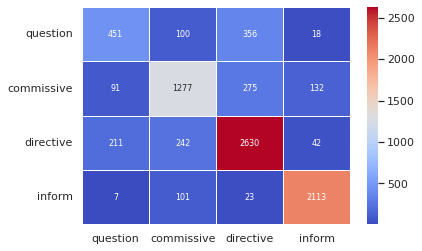

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn

cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

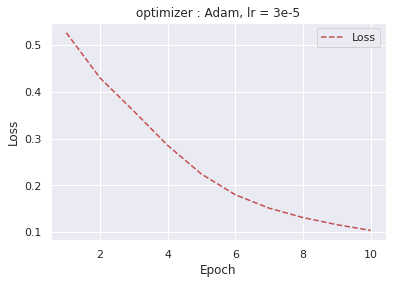

<Figure size 1152x648 with 0 Axes>

In [ ]:
# Create count of the number of epochs
epoch_count = range(1, len(total_loss) + 1)

# Visualize loss history
plt.title('optimizer : Adam, lr = 3e-5')
plt.plot(epoch_count, total_loss, 'r--')
plt.legend(['Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.figure(figsize=(16,9))
plt.show()

# <font color="chillipepper">**Bert - CNN - BiGRU - Attention Hybrid Model** </font>

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel


class BERT_CNN_BiGRU_Attention(nn.Module):
    
    def __init__(self, num_classes, dropout_rate):
        super().__init__()

        #Parameters
        self.embedding_dim = 768 #bert embeddings
        self.hidden_dim = 128
        self.num_layers = 2
        self.num_classes = num_classes
        self.out_channels = 16
        self.Kernels = [3,4,5]
        self.dropout_rate = dropout_rate

        #Bert
        self.bert = BertModel.from_pretrained("bert-base-cased")

        #CNN
        self.conv1 =  nn.Conv1d(in_channels=self.embedding_dim, out_channels=self.out_channels, kernel_size= self.Kernels[0])
        self.conv2 =  nn.Conv1d(in_channels=self.embedding_dim, out_channels=self.out_channels, kernel_size= self.Kernels[1])
        self.conv3 =  nn.Conv1d(in_channels=self.embedding_dim, out_channels=self.out_channels, kernel_size= self.Kernels[2])

        #BiGru
        self.bigru = nn.GRU(input_size=self.embedding_dim, hidden_size=self.hidden_dim, num_layers=self.num_layers, bidirectional=True, batch_first=True)

        #Attention
        self.attention = nn.Linear(in_features=self.hidden_dim * 2, out_features=1)

        #Linear
        L = len(self.Kernels) * self.out_channels + self.hidden_dim * 2
        self.fc = nn.Linear(in_features=L, out_features=self.num_classes)

        #Dropout
        self.dropout = nn.Dropout(self.dropout_rate)

        #SoftMax
        self
    
    def forward(self, input_ids, attention_mask):

        #Bert
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state.permute(0, 2, 1) # change tensor shape from (batch_size, sequence_length, hidden_size) to (batch_size, hidden_size, sequence_length)
        
        #CNN
        cnn_output1 = F.relu(self.conv1(sequence_output))
        cnn_output2 = F.relu(self.conv2(sequence_output))
        cnn_output3 = F.relu(self.conv3(sequence_output))
        max_pool1 = F.max_pool1d(cnn_output1, kernel_size=cnn_output1.shape[2]).squeeze()
        max_pool2 = F.max_pool1d(cnn_output2, kernel_size=cnn_output2.shape[2]).squeeze()
        max_pool3 = F.max_pool1d(cnn_output3, kernel_size=cnn_output3.shape[2]).squeeze()
        conv_output = torch.cat([max_pool1, max_pool2, max_pool3], dim=1)
        conv_output = self.dropout(conv_output)

        #BiGRU
        bigru_output, _ = self.bigru(outputs.last_hidden_state)

        #Attention
        attention_output = self.attention(bigru_output).squeeze(2)
        attention_weights = F.softmax(attention_output, dim=1).unsqueeze(2)
        weighted_sum = torch.sum(bigru_output * attention_weights, dim=1)

        #CNN and BiGRU-Attention Cat
        final_output = torch.cat((conv_output, weighted_sum), dim=1)

        #Linear
        logits = self.fc(final_output)
        return logits

# <font color="chillipepper">**Bert - CNN - BiGRU - Attention Hybrid Model Training** </font>

In [18]:
if torch.cuda.is_available():
    device = 'cuda'
    print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
    device = 'cpu'
    print('DEVICE = ', colored('CPU', "blue"))

model = BERT_CNN_BiGRU_Attention(num_classes = len(names), dropout_rate = 0.75)
model = model.to(device)

from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=3e-5)

from transformers import get_scheduler

num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

DEVICE =  NVIDIA A100-SXM4-40GB


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
total_accuracy = 0
total_loss = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0 
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        sent_id = batch['input_ids']
        mask = batch['attention_mask']
        labels = batch['labels']
        del batch

        model.zero_grad()

        outputs = model(sent_id, mask)
        loss = F.cross_entropy(outputs, labels)
        running_loss += float(loss.item())

        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    total_loss.append(running_loss/len(train_dataloader))

  0%|          | 0/6820 [00:00<?, ?it/s]

# <font color="chillipepper">**Bert - CNN - BiGRU - Attention Hybrid** </font>

In [20]:
from datasets import load_metric
metric = load_metric("accuracy")
model.eval()
preds, trues = [], []
for i, batch in tqdm(enumerate(eval_dataloader), desc="evaluating", total=eval_dataloader.__len__()):
    batch = {k: v.to(device) for k, v in batch.items()}
    sent_id = batch['input_ids']
    mask = batch['attention_mask']
    labels = batch['labels']
    del batch
    with torch.no_grad():
        outputs = model(sent_id, mask)

    logits = outputs
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=labels)

    _, tag_seq  = torch.max(logits, 1)
    preds.extend(tag_seq.cpu().detach().tolist())
    trues.extend(labels.cpu().detach().tolist())

metric.compute()

evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

{'accuracy': 0.8023299045730574}

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names))

              precision    recall  f1-score   support

    question       0.59      0.50      0.54       925
      inform       0.76      0.71      0.73      1775
   directive       0.79      0.85      0.82      3125
  commissive       0.92      0.94      0.93      2244

    accuracy                           0.80      8069
   macro avg       0.77      0.75      0.76      8069
weighted avg       0.80      0.80      0.80      8069



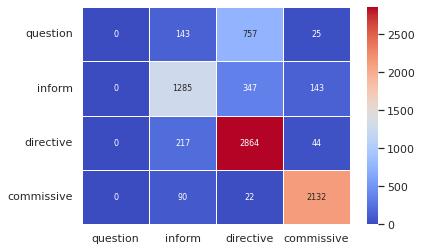

In [15]:
import matplotlib.pyplot as plt
import seaborn as sn

cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

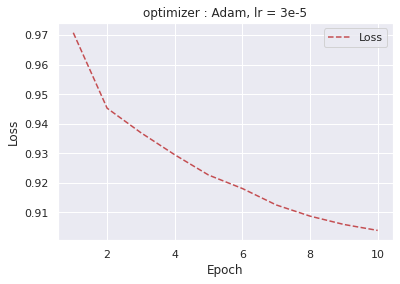

<Figure size 1152x648 with 0 Axes>

In [16]:
# Create count of the number of epochs
epoch_count = range(1, len(total_loss) + 1)

# Visualize loss history
plt.title('optimizer : Adam, lr = 3e-5')
plt.plot(epoch_count, total_loss, 'r--')
plt.legend(['Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.figure(figsize=(16,9))
plt.show()